# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Success")

Success


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [5]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

print("Success running kernel")

Success running kernel


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

cv_num_iters = 200
lr_range = [1e-8, 1e-6]
regularization_range = [1e4, 1e7]

def sample_hyperparam(valrange,use_log=False):
    if use_log:
        minval = np.log10(valrange[0])
        maxval = np.log10(valrange[1])
    else:
        minval = valrange[0]
        maxval = valrange[1]
    randval = np.random.rand()*(maxval-minval) + minval
    if use_log:
        return 10**randval
    else:
        return randval
    
    
for _ in range(100):
    cv_lr = sample_hyperparam(lr_range,use_log=True)
    cv_reg = sample_hyperparam(regularization_range,use_log=True)
    cv_svm = LinearSVM()
    cv_loss_hist = cv_svm.train(X_train_feats, y_train, learning_rate=cv_lr, reg=cv_reg,
                              num_iters=cv_num_iters, verbose=False)
    cv_train_acc = np.mean(y_train == cv_svm.predict(X_train_feats))
    cv_val_acc = np.mean(y_val == cv_svm.predict(X_val_feats))
    results[(cv_lr,cv_reg)] = (cv_train_acc,cv_val_acc)
    if cv_val_acc > best_val:
        best_svm = cv_svm
        best_val = cv_val_acc
        best_reg = cv_reg
        best_lr = cv_lr
        print('Current best val accuracy',best_val,'For lr',best_lr,'reg',best_reg)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Current best val accuracy 0.141 For lr 1.8555109332369923e-08 reg 74437.59055144354
Current best val accuracy 0.397 For lr 2.0730406104505265e-07 reg 242034.59114968768
Current best val accuracy 0.398 For lr 2.417174931502183e-08 reg 5577133.9738798905
Current best val accuracy 0.408 For lr 1.5431282067746203e-07 reg 810470.9228855651
Current best val accuracy 0.416 For lr 2.791035839048662e-08 reg 1108558.8485309863
Current best val accuracy 0.424 For lr 4.409954928620994e-08 reg 1207112.3078052665
Current best val accuracy 0.435 For lr 2.2762944517326887e-08 reg 1376482.648253679


C:\Users\Sagnik\Work\DNN-Hub\CS231N\assignment1\cs231n\classifiers\linear_svm.py:97: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
C:\Users\Sagnik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Sagnik\Work\DNN-Hub\CS231N\assignment1\cs231n\classifiers\linear_svm.py:97: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


lr 1.095812e-08 reg 6.357563e+05 train accuracy: 0.104980 val accuracy: 0.090000
lr 1.236760e-08 reg 1.009959e+06 train accuracy: 0.101000 val accuracy: 0.100000
lr 1.284819e-08 reg 4.691352e+05 train accuracy: 0.095735 val accuracy: 0.097000
lr 1.360080e-08 reg 8.758869e+06 train accuracy: 0.389735 val accuracy: 0.392000
lr 1.381031e-08 reg 5.809560e+05 train accuracy: 0.080347 val accuracy: 0.084000
lr 1.446608e-08 reg 3.893942e+04 train accuracy: 0.110245 val accuracy: 0.100000
lr 1.499080e-08 reg 3.527031e+04 train accuracy: 0.118388 val accuracy: 0.109000
lr 1.635774e-08 reg 8.847150e+04 train accuracy: 0.120898 val accuracy: 0.104000
lr 1.819100e-08 reg 2.311006e+05 train accuracy: 0.118918 val accuracy: 0.110000
lr 1.834866e-08 reg 1.241048e+04 train accuracy: 0.119673 val accuracy: 0.129000
lr 1.855511e-08 reg 7.443759e+04 train accuracy: 0.126633 val accuracy: 0.141000
lr 1.875745e-08 reg 1.351270e+05 train accuracy: 0.107429 val accuracy: 0.105000
lr 1.878044e-08 reg 6.217328

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


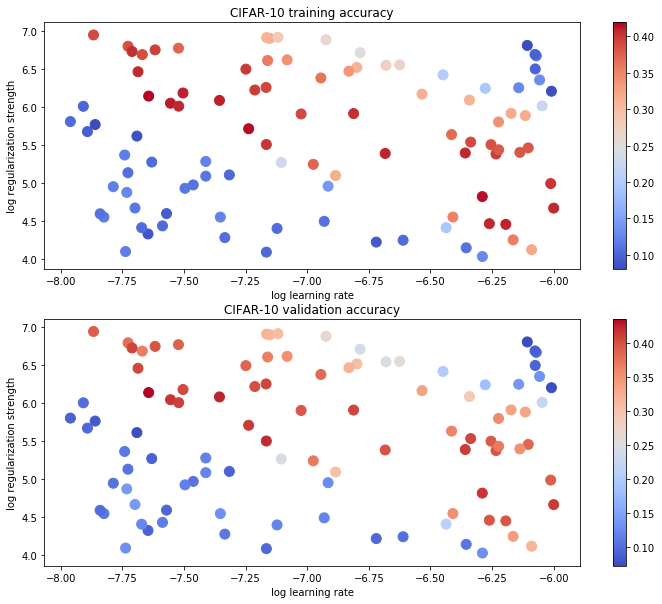

In [10]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

plt.rcParams['figure.figsize'] = (12.0, 10.0)

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

plt.rcParams['figure.figsize'] = (10.0, 8.0)

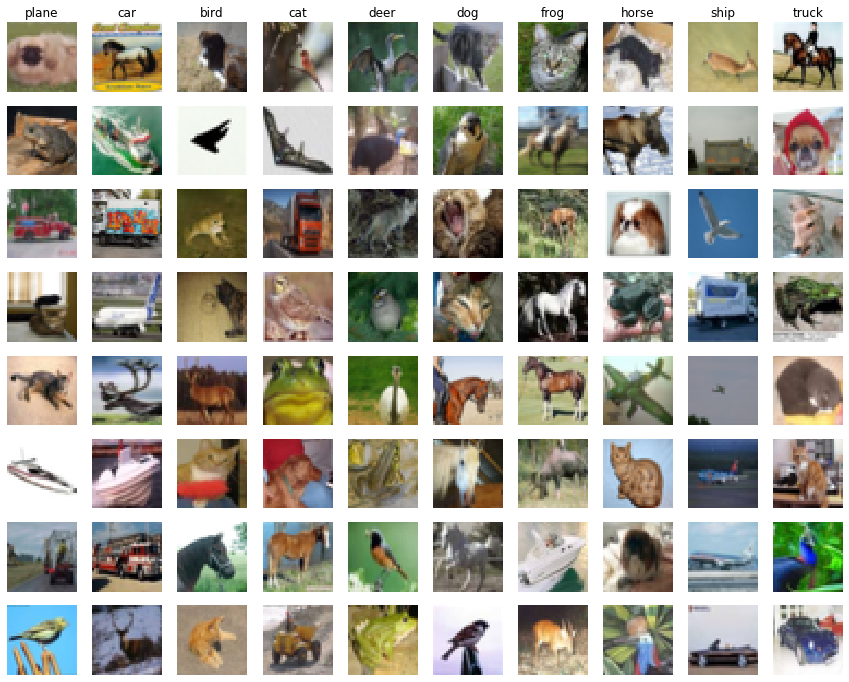

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
plt.rcParams['figure.figsize'] = (15.0, 12.0)
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()
plt.rcParams['figure.figsize'] = (10.0, 8.0)

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ 1) Plane - streamline features of objects are missclassified
                                     2) Car - 
                                     3) Bird - 
                                     4) cat -
                                     5) deer - 
                                     6) dog -
                                     7) frog = 
                                     8) horse - 
                                     9) ship - 
                                     10) truck - 




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [15]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import time
results = {}

def sample_hyperparam(valrange,use_log=False):
    if use_log:
        minval = np.log10(valrange[0])
        maxval = np.log10(valrange[1])
    else:
        minval = valrange[0]
        maxval = valrange[1]
    randval = np.random.rand()*(maxval-minval) + minval
    if use_log:
        return 10**randval
    else:
        return randval

def hyperparam_run(hidden_sizelist, lr_range, reg_range, X_train, y_train, X_val, y_val, num_points, num_inits, num_iters):
    best_val = -1
    tic = time.time()
    for pt in range(1,num_points+1):
        lr = sample_hyperparam(lr_range,use_log=True)
        reg = sample_hyperparam(reg_range,use_log=True)
        for hs in hidden_sizelist:
            val_accuracies = []
            for _ in range(num_inits):
                net = TwoLayerNet(input_dim, hs, num_classes)
                net.train(X_train, y_train, X_val, y_val, 
                                      learning_rate=lr, reg=reg,
                                      num_iters=num_iters, verbose=False)
                val_acc = (net.predict(X_val) == y_val).mean()
                val_accuracies.append(val_acc)
            val_acc = np.mean(np.array(val_accuracies))
            results[(hs,lr,reg)] = val_acc
            if val_acc > best_val:
                best_val = val_acc
                print('Current best val accuracy',best_val,'For lr',lr,'reg',reg,'Hidden size',hs)
        if pt % (num_points//10) == 0:
            print(pt,'points done')
        if pt == 1:
            timediff = time.time() - tic
            print('Time elapsed for 1 point %fs'%timediff)
            print('Expeceted total time %fs'%(timediff*num_points))
    timediff = time.time() - tic
    print('Total time elapsed',timediff)
    return results

In [17]:
# Course parameter range
hidden_sizes = [500]
learning_rate_range = [3.4e-2,1e1]
regularization_range = [1e-5,1e-6]
learning_rate_decay = 0.95
batch_size = 200
print("start hyper-parameter run")

course_results = hyperparam_run(hidden_sizes, learning_rate_range, regularization_range,
                               X_train_feats, y_train, X_val_feats, y_val,
                               num_points=50,num_inits=3,num_iters=20)

start hyper-parameter run
Current best val accuracy 0.078 For lr 0.05611263243040627 reg 4.166803459142551e-06 Hidden size 500
Time elapsed for 1 point 72.182547s
Expeceted total time 3609.127367s
Current best val accuracy 0.225 For lr 0.9751111513426408 reg 1.5193519525264566e-06 Hidden size 500
Current best val accuracy 0.36900000000000005 For lr 2.5228079001923907 reg 1.8620809143240027e-06 Hidden size 500
Current best val accuracy 0.39233333333333337 For lr 2.55898803092971 reg 9.714934159648899e-06 Hidden size 500
5 points done
10 points done
15 points done
Current best val accuracy 0.4046666666666667 For lr 2.3452788539433924 reg 9.194445296197373e-06 Hidden size 500
20 points done
25 points done
30 points done
35 points done
40 points done
45 points done
50 points done
Total time elapsed 3265.3457531929016


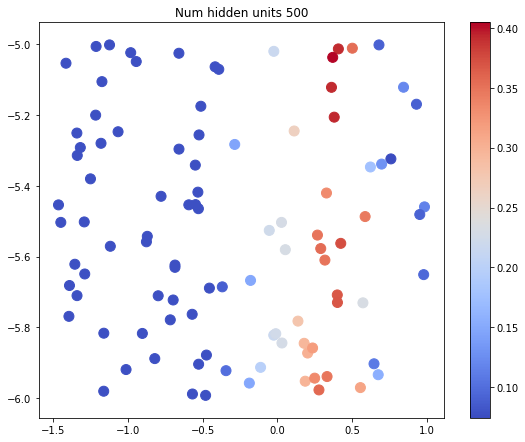

In [18]:
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
import math
for i,hs in enumerate(hidden_sizes):
    lr_scatter = [math.log10(x[1]) for x in course_results if x[0]==hs]
    reg_scatter = [math.log10(x[2]) for x in course_results if x[0]==hs]
    marker_size = 100
    colors = [results[x] for x in course_results if x[0]==hs]
    plt.subplot(2, 2, i+1)
    plt.scatter(lr_scatter, reg_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
    plt.colorbar()
    plt.title('Num hidden units '+str(hs))
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

In [21]:
tuned_reg = 1e-5
tuned_lr = 3.4

best_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
train_results = best_net.train(X_train_feats, y_train, X_val_feats, y_val, 
                                      learning_rate  =tuned_lr , reg=tuned_reg ,
                                      num_iters=1500, verbose=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.201873
iteration 200 / 1500: loss 1.031936
iteration 300 / 1500: loss 0.891926
iteration 400 / 1500: loss 0.699291
iteration 500 / 1500: loss 0.487103
iteration 600 / 1500: loss 0.513705
iteration 700 / 1500: loss 0.443717
iteration 800 / 1500: loss 0.232209
iteration 900 / 1500: loss 0.215423
iteration 1000 / 1500: loss 0.177604
iteration 1100 / 1500: loss 0.125187
iteration 1200 / 1500: loss 0.112727
iteration 1300 / 1500: loss 0.096738
iteration 1400 / 1500: loss 0.086412


In [22]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.553
